<a href="https://colab.research.google.com/github/FrancescaMoi/SentimentAnalysis/blob/main/sentyment_analysis_IMDb_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment analysis**
La **sentiment analysis** è una tecnica di *Natural Language Processing* che consiste nell'identificare l'intenzione/sentimento che sta dietro un testo. 

Questo tipo di analisi viene spesso eseguita sui feedback dei clienti per aiutare le aziende a monitorare il grado di apprezzamento del proprio prodotto e comprendere le esigenze dei clienti.

## **Caricamento del dataset**

Il dataset utilizzato consiste in un CSV contenente un elenco di 50K recensioni di film messe a disposizione dalla piattaforma [*kaggle*](https://www.kaggle.com/), precedentemente etichettate come positive o negative. Il CSV può essere scaricato al seguente link:
[*IMDb dataset*](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

Una volta scaricato il CSV, carichiamo in memoria il dataset sfruttando le funzionalità della libreria [pandas](https://pandas.pydata.org/docs/index.html):

In [93]:
import pandas as pd

df = pd.read_csv("drive/MyDrive/Colab Notebooks/PilloleIA/data/IMDB Dataset.csv")

### **Colonne del dataset**
La colonna *review * contiene l'informazione testuale di input e la colonna *sentiment* contiene la label che vogliamo ottenere in output. L'obiettivo del classificatore che andremo a creare è quella di predire la label *sentiment* data in input il testo di una *review*.

Vediamo come si presenta il dataset prendendo le prime 5 righe:

In [74]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## **Analisi del dataset**

Una delle fasi più importanti nello sviluppo di un sistema di IA è l'**analisi del dataset**. E' indispensabile essere a conoscenza di come si presenta il dato che si ha disposizione e di come sono distribuite le classi all'interno del dataset.

### **Analisi numerosità e presenza di valori nulli**

Per prima cosa verifichiamo la numerosità dei dati a nostra disposizione:

In [75]:
# Numerosità dataset
df.shape

(50000, 2)

Verifichiamo poi la presenza di valori nulli all'interno del dataframe e, in caso positivo andiamo a rimuoverli:

In [76]:
# Analisi presenza di valori nulli
df.isnull().any() 

review       False
sentiment    False
dtype: bool

Come si può vedere, il dataset non contiene valori nulli nè all'interno della colonna *review*, nè nella colonna *sentiment*.

### **Analisi distribuzione delle classi**
Possiamo procedere analizzando **come i valori della colonna target si distribuiscono sul dataset**. Per fare ciò sfruttiamo le funzionalità offerte dalle librerie [seaborn](https://seaborn.pydata.org/) e [matplotlib](https://matplotlib.org/) che ci forniscono una visualizzazione grafica della distribuzione dei dati contenuti **nella** colonna *sentiment*.

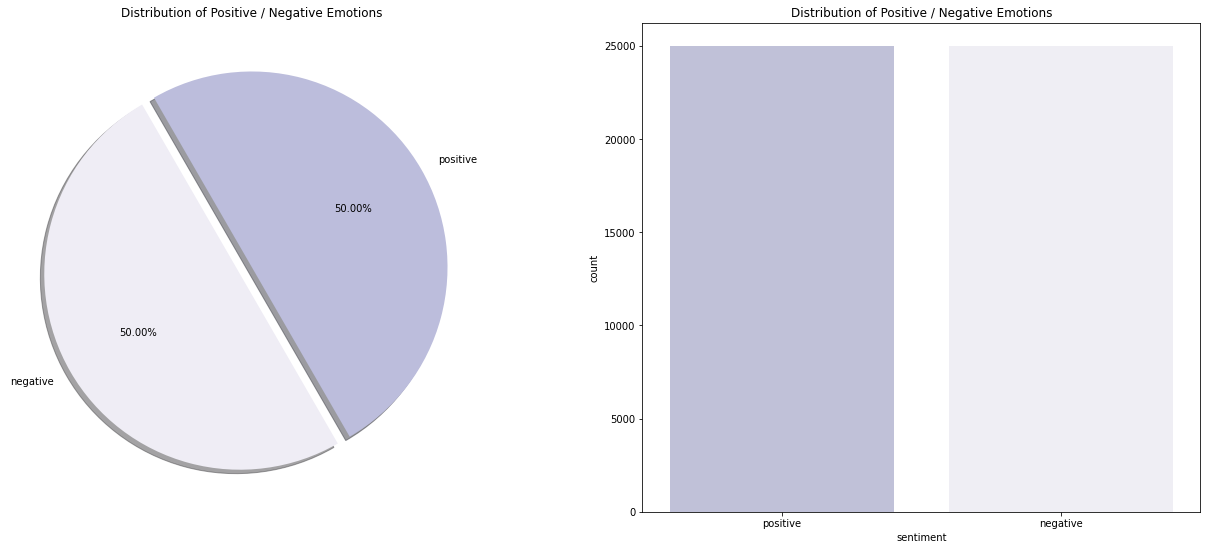

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

fig , ax = plt.subplots(1,2,figsize=(22,9))

# Grafico a torta con matplotlib
df['sentiment'].value_counts().plot.pie(explode=[0,0.07],
                                        autopct='%1.2f%%',
                                        ax=ax[0],
                                        shadow=True,
                                        startangle=300,
                                        colors = ["#bcbddc", "#efedf5"])
ax[0].set_ylabel('')
ax[0].set_title('Distribution of Positive / Negative Emotions')

# Istogramma con seaborn
sns.countplot(x=df['sentiment'],
              ax=ax[1],
              palette=["#bcbddc", "#efedf5"])

ax[1].set_title('Distribution of Positive / Negative Emotions')

plt.show()

Come si può notare dai grafici, il dataset è **perfettamente bilanciato**: il 50% delle review appartengono alla classe *positive* e il restante 50% appartengono alla classe *negative*.

Analisi testo

In [82]:
from collections import Counter

def get_most_common_words(df, sentiment):
  review_corpus = df[df['sentiment']==sentiment]['review'].str.lower().str.split()
  review_corpus = [word for review in review_corpus for word in review]
  counter=Counter(review_corpus)
  most_common_words=counter.most_common()
  words, count = zip(*most_common_words[:100])
  return words, count

def print_words_distribution(df):
  fig , ax = plt.subplots(1,2,figsize=(15,20))
  words, count = get_most_common_words(df, sentiment='positive')
  sns.barplot(x=list(count),y=list(words), ax=ax[0])
  words, count = get_most_common_words(df, sentiment='negative')
  sns.barplot(x=list(count),y=list(words), ax=ax[1])

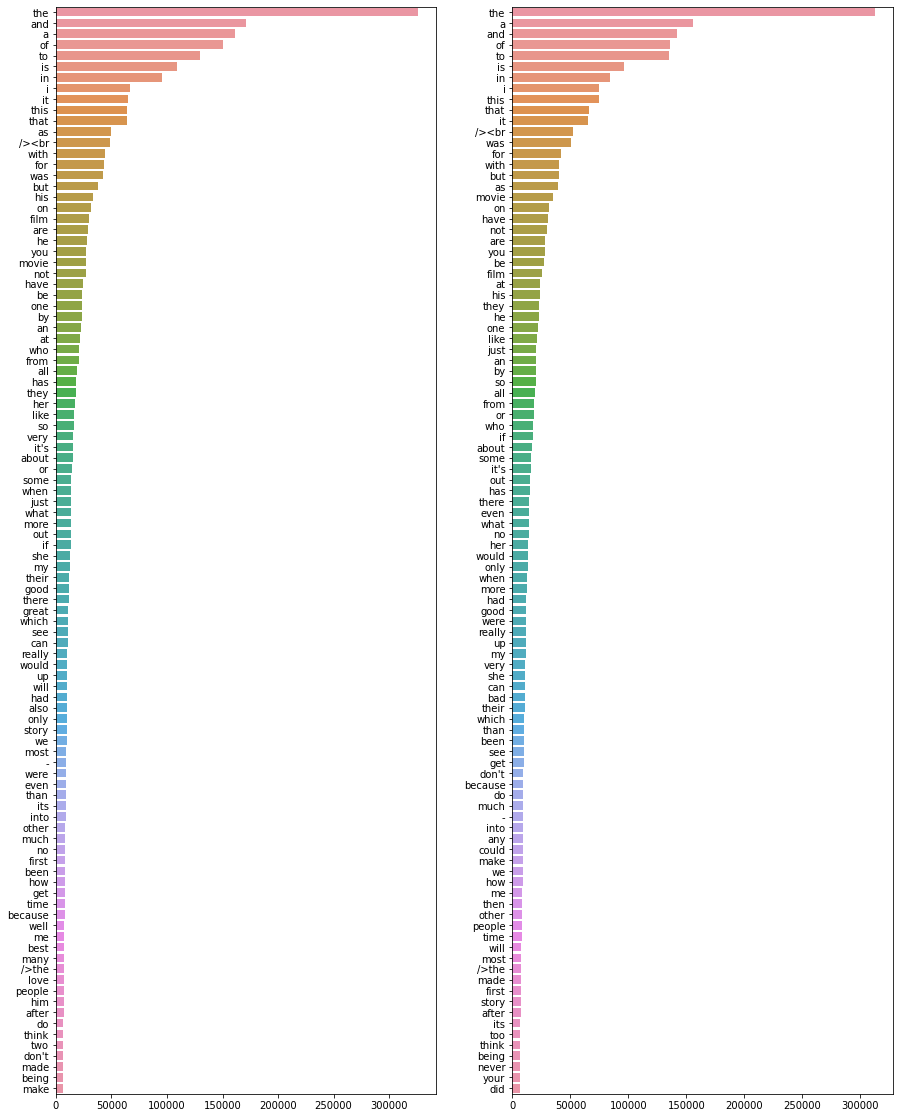

In [83]:
print_words_distribution(df)

In [106]:
from statistics import mean
print(f"Minimum review length: {min(count_words)}")
print(f"Maximum review length: {max(count_words)}")
print(f"Mean review length: {mean(count_words)}")

Minimum review length: 3
Maximum review length: 1416
Mean review length: 118.12708


In [49]:
words_gt_200 = [l for l in count_words if l > 150]
len(words_gt_200)

11600

## **Data Cleaning**
La fase di pulizia dei dati è la fase più importante nella creazione di un modello di IA efficace. Se i dati di input sono sporchi il modello di NLP non riesce ad imparare correttamente le regole e le logiche che si nascondono nel testo, ottenendo dei risultati scarsi.

Vediamo ad esempio la prima review presente nel dataset:

In [7]:
example_review = df.loc[0, 'review']
example_review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

### Rimozione tag html

In [8]:
from bs4 import BeautifulSoup

example_review = BeautifulSoup(example_review).get_text()
example_review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

Rimozione caratteri speciali


In [9]:
import re

example_review = re.sub("[^a-zA-Zàèéìòù\s]", " ", example_review) # rimozione caratteri numerici o segni di punteggiatura
example_review = re.sub("\s+", " ", example_review) # rimozione spazi multipli
example_review = example_review.strip() # rimozione spazi all'inizio e alla fine della stringa
example_review

'One of the other reviewers has mentioned that after watching just Oz episode you ll be hooked They are right as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to many Aryans Muslims gangstas Latinos Christians Italians Irish and more so scuffles death stares dodgy dealings and shady agreements are never far away I would say the main appeal of the show is due to the fact that it goes where other shows wouldn t dare Forget pretty p

Testo in lower case

In [10]:
example_review = example_review.lower() # trasformazione del testo in lower case
example_review

'one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wouldn t dare forget pretty p

Rimozione stopwords

In [11]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [12]:
review_tokens = [word for word in example_review.split() if word not in stop_words] # trasformazione in lista di token e rimozione delle stopwords
review_tokens

['one',
 'reviewers',
 'mentioned',
 'watching',
 'oz',
 'episode',
 'hooked',
 'right',
 'exactly',
 'happened',
 'first',
 'thing',
 'struck',
 'oz',
 'brutality',
 'unflinching',
 'scenes',
 'violence',
 'set',
 'right',
 'word',
 'go',
 'trust',
 'show',
 'faint',
 'hearted',
 'timid',
 'show',
 'pulls',
 'punches',
 'regards',
 'drugs',
 'sex',
 'violence',
 'hardcore',
 'classic',
 'use',
 'word',
 'called',
 'oz',
 'nickname',
 'given',
 'oswald',
 'maximum',
 'security',
 'state',
 'penitentary',
 'focuses',
 'mainly',
 'emerald',
 'city',
 'experimental',
 'section',
 'prison',
 'cells',
 'glass',
 'fronts',
 'face',
 'inwards',
 'privacy',
 'high',
 'agenda',
 'em',
 'city',
 'home',
 'many',
 'aryans',
 'muslims',
 'gangstas',
 'latinos',
 'christians',
 'italians',
 'irish',
 'scuffles',
 'death',
 'stares',
 'dodgy',
 'dealings',
 'shady',
 'agreements',
 'never',
 'far',
 'away',
 'would',
 'say',
 'main',
 'appeal',
 'show',
 'due',
 'fact',
 'goes',
 'shows',
 'dare',
 

In [14]:
cleaned_review = ' '.join(review_tokens)
cleaned_review

'one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skill

Eseguiamo la pulizia a tutti i record del dataset

In [104]:
def clean_text(review):
  review = BeautifulSoup(review).get_text()
  review = re.sub("[^a-zA-Zàèéìòù\s]", " ", review) # rimozione di caratteri numerici o segni di punteggiatura
  review = re.sub("\s+", " ", review) # rimozione spazi multipli
  review = review.strip() # rimozione spazi all'inizio e alla fine della stringa
  review = review.lower() # trasformazione del testo in lower case
  text_tokens = [word for word in review.split() if word not in stop_words] # rimozione stopwords
  cleaned_text = ' '.join(text_tokens)
  return cleaned_text

df['review'] = df['review'].apply(lambda x: clean_text(x))
df['review']

0        one reviewers mentioned watching oz episode ho...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically family little boy jake thinks zombie...
4        petter mattei love time money visually stunnin...
                               ...                        
49995    thought movie right good job creative original...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary schools n...
49998    going disagree previous comment side maltin on...
49999    one expects star trek movies high art fans exp...
Name: review, Length: 50000, dtype: object

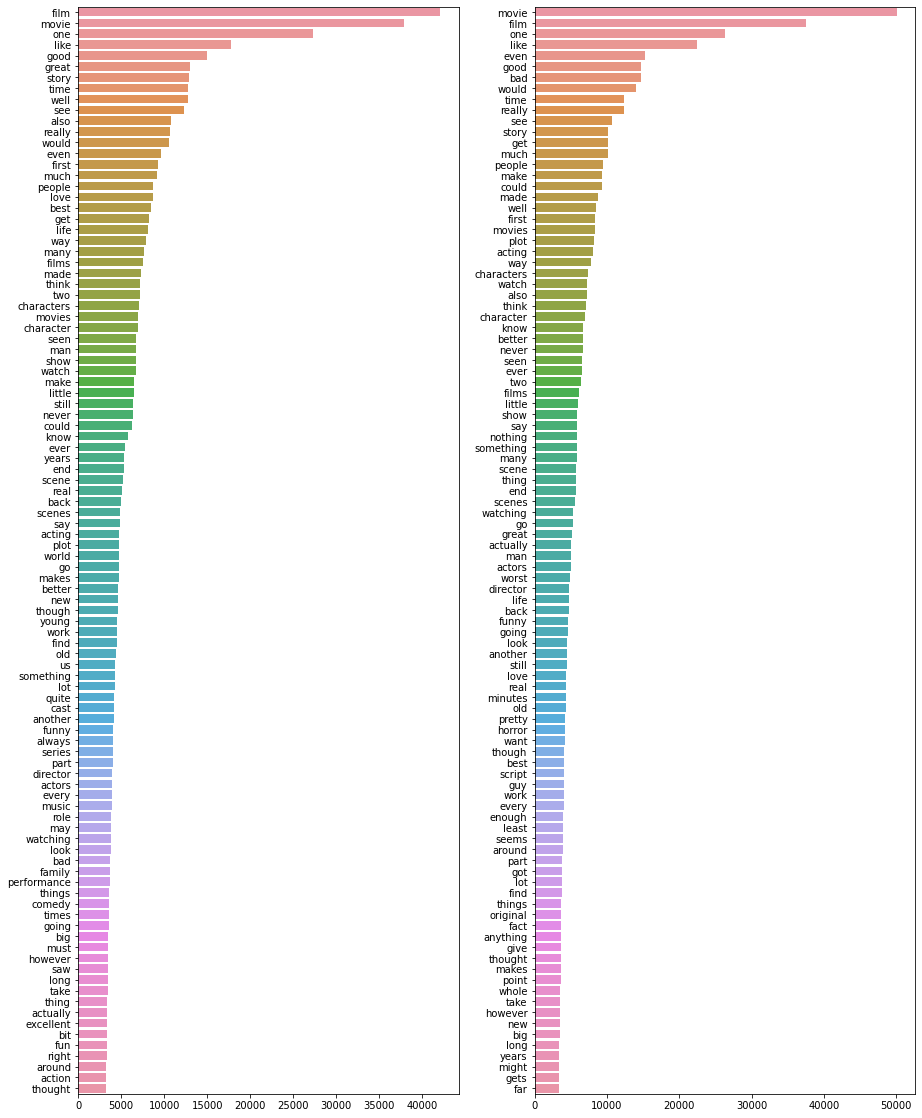

In [85]:
print_words_distribution(df)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


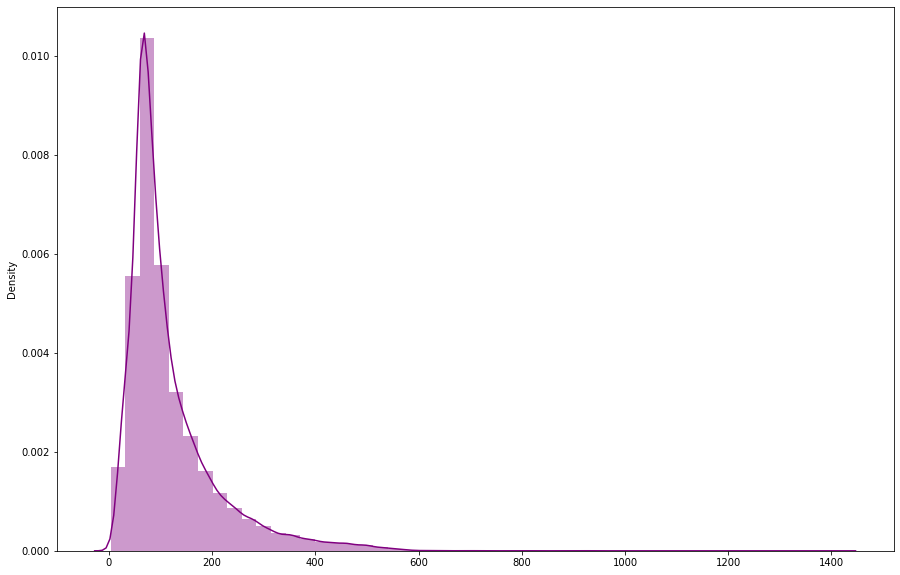

In [107]:
count_words = df['review'].apply(lambda x: len(x.split())).to_list()
plt.figure(figsize=(15,10))
sns.distplot(count_words,color='Purple')
plt.show()    

**Split the dataset**

In [16]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])

print("Train set shape: ", df_train.shape)
print("Test set shape: ", df_test.shape)

print("\nTrain set classes distribution:\n", df_train['sentiment'].value_counts())
print("\nTest set classes distribution:\n", df_test['sentiment'].value_counts())



Train set shape:  (40000, 2)
Test set shape:  (10000, 2)

Train set classes distribution:
 positive    20000
negative    20000
Name: sentiment, dtype: int64

Test set classes distribution:
 negative    5000
positive    5000
Name: sentiment, dtype: int64


**Vectorize texts**

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1416)
train_vectors = vectorizer.fit_transform(df_train['review'])
test_vectors = vectorizer.transform(df_test['review'])


In [110]:
vectorized_train_df = pd.DataFrame(train_vectors.toarray(), columns=vectorizer.get_feature_names_out())
vectorized_train_df.head()


,ability,able,absolute,absolutely,accent,across,act,acted,acting,action,...,yeah,year,years,yes,yet,york,young,younger,zombie,zombies
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.077238,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.12045,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Training**

In [111]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_vectors, df_train['sentiment'])

RandomForestClassifier(random_state=42)

In [112]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(train_vectors, df_train['sentiment'])

LogisticRegression()

In [113]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(train_vectors, df_train['sentiment'])

KNeighborsClassifier()

**Testing and results evaluation**

In [114]:
from sklearn.metrics import accuracy_score,precision_score,recall_score, f1_score
def model_evaluation(model, test_vec, y_test):
  y_pred = model.predict(test_vec)
  y_test = df_test['sentiment']

  accuracy = round(accuracy_score(y_test, y_pred), 3)
  precision = round(precision_score(y_test, y_pred, pos_label='positive'), 3)
  recall = round(recall_score(y_test, y_pred, pos_label='positive'), 3)
  f1 = round(f1_score(y_test,y_pred, pos_label='positive'), 3)

  print("Accuracy: ", accuracy)
  print("Precision: ", precision)
  print("Recall: ", recall)
  print("F1_score: ", f1)

In [115]:
model_evaluation(rf_model, test_vectors, df_test['sentiment'])

Accuracy:  0.843
Precision:  0.845
Recall:  0.84
F1_score:  0.842


In [116]:
model_evaluation(lr_model, test_vectors, df_test['sentiment'])

Accuracy:  0.878
Precision:  0.874
Recall:  0.882
F1_score:  0.878


In [ ]:
model_evaluation(knn_model, test_vectors, df_test['sentiment'])